In [7]:
import torch
import numpy as np
from MI_SegNet import Seg_encoder_LM,Seg_decoder_LM
import os
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import copy
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall

In [2]:
device='cuda'
best_path = './ckpt/Trained_Model/model_best.pth'

In [3]:
bestPara=torch.load(best_path,map_location=device)
print(bestPara['best_test_loss'], bestPara['epoch'])

tensor(0.1858, device='cuda:0') 30


In [4]:
best_Seg_encoder = Seg_encoder_LM(1,64,2).to(device)
best_Seg_decoder = Seg_decoder_LM(1,64,2).to(device)

In [5]:
best_Seg_encoder.load_state_dict(bestPara['state_dict_seg_en'])

best_Seg_decoder.load_state_dict(bestPara['state_dict_seg_de'])

print(bestPara['best_test_loss'], bestPara['epoch'])
del bestPara
torch.cuda.empty_cache()

tensor(0.1858, device='cuda:0') 30


In [8]:
test_path='/home/robotics-meta/Project/yuanBi/Mutual_Info/github/MI_SegNet_dataset/TS3'
files_img=os.listdir(os.path.join(test_path,'img'))
files_img.sort()
files_label=os.listdir(os.path.join(test_path,'label'))
files_label.sort()
dice_avg=[]
precision_avg=[]
recall_avg=[]
###############################################
transform_image=transforms.Normalize(0.5,0.5)
###################################################

precision_m = BinaryPrecision()
recall_m = BinaryRecall()

for i in range(len(files_img)):
    img_path=os.path.join(test_path,'img',files_img[i])
    label_path=os.path.join(test_path,'label',files_label[i])
    
    src=cv2.imread(img_path)
    img = cv2.resize(src, (256,256),interpolation=cv2.INTER_LANCZOS4)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    
    src = cv2.imread(label_path)
    label = cv2.resize(src, (256,256),interpolation=cv2.INTER_LANCZOS4)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    
    x = torch.from_numpy(img).float().to(device).view(-1,256,256)
    l = torch.from_numpy(label).to(device).view(-1,256,256)
    
    x=transform_image(x)
    
    x = x.view(-1,1,256,256)
    
    z = best_Seg_encoder(x)
    pred = best_Seg_decoder(z).view(-1,256,256)
    pred_np = pred.view(256,256).cpu().detach().numpy()

    dice = (2*np.sum(pred_np.flatten()*label.flatten())+2)/(np.sum(pred_np)+np.sum(label)+2)
    dice_avg.append(dice)
    
    precision = precision_m(pred.squeeze(),l.squeeze())
    precision_avg.append(precision.cpu().detach().numpy())
    
    recall = recall_m(pred.squeeze(),l.squeeze())
    recall_avg.append(recall.cpu().detach().numpy())
    
dice_avg=np.array(dice_avg)
precision_avg = np.array(precision_avg)
recall_avg = np.array(recall_avg)
print('Dice Avg:',dice_avg.mean(),'Dice Std:',dice_avg.std())
print('Precision Avg:',precision_avg.mean(),'Precision Std:',precision_avg.std())
print('Recall Avg:',recall_avg.mean(),'Recall Std:',recall_avg.std())


Dice Avg: 0.8206733030758847 Dice Std: 0.14591141162780036
Precision Avg: 0.8352771 Precision Std: 0.20423533
Recall Avg: 0.8704513 Recall Std: 0.090117335


540


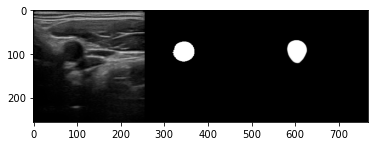

In [9]:
test_path='/home/robotics-meta/Project/yuanBi/Mutual_Info/github/MI_SegNet_dataset/TS3'
files_img=os.listdir(os.path.join(test_path,'img'))
files_img.sort()
files_label=os.listdir(os.path.join(test_path,'label'))
files_label.sort()

print(len(files_img))

i=36

img_path=os.path.join(test_path,'img',files_img[i])
label_path=os.path.join(test_path,'label',files_label[i])

src=cv2.imread(img_path)
img = cv2.resize(src, (256,256),interpolation=cv2.INTER_LANCZOS4)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img/255

src = cv2.imread(label_path)
label = cv2.resize(src, (256,256),interpolation=cv2.INTER_LANCZOS4)
label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
#     labels = torch.from_numpy(label).float().to(device)

x = torch.from_numpy(img).float().to(device).view(-1,256,256)
l = torch.from_numpy(label).to(device).view(-1,256,256)

x=transform_image(x)

x = x.view(-1,1,256,256)

z = best_Seg_encoder(x)
pred = best_Seg_decoder(z).view(-1,256,256)
pred_np = pred.view(256,256).cpu().detach().numpy()

img_plot = np.concatenate((img,label,pred_np),axis=1)
plt.imshow(img_plot,cmap='gray')